# Implementing Hyperbolic SVM
`Drew Wilimitis`

In this notebook, I attempt to implement another foundational supervised learning algorithm in hyperbolic space to continue exploring how hyperbolic embeddings can be integrated with downstream machine learning tasks in order to fully exploit the representational capacity of hyperbolic geometry. <br>
<br>
I follow the approach recently outlined in "Large-margin classification in hyperbolic space". Cho, H., Demeo, B., Peng, J., Berger, B. CoRR abs/1806.00437 (2018)

## Algorithm Outline

Given data in the Poincare disk $x_1, \ldots , x_N \in \mathcal{B}^{d}$, partition the $N$ observations into k sets denoted by $\mathbf{S}=\left\{S_{1}, S_{2}, \ldots, S_{k}\right\}$, where we have $k$ centroids or means $\left\{\boldsymbol{m}_{i}^{(t)}\right\}_{i=1}^{k}$ at each iteration $t$. <br>
<br>
The basic steps in Hyperbolic k-means are: <br>
1. **Initialization step**: initialize k random centroids $\left\{\boldsymbol{m}_{i}^{(t)}\right\}_{i=1}^{k} \in \mathcal{B}^{d}$<br>
2. **Assignment step**: assign each $x_p$ to nearest centroid with smallest poincare distance<br>
3. **Project to H**: project to hyperboloid model<br>
4. **Update step**: calculate new means with optimization in Hyperboloid model <br>
5. **Project back to Poincare disk**: map back into poincare disk model
6. **Repeat steps 2-5 until stopping criteria** <br>
7. **Return:** cluster labels for all $x_i$ and cluster means $\left\{\boldsymbol{m}_{i}\right\}_{i=1}^{k}$

## Load libraries and helper functions

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import time
plt.style.use('seaborn')
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import check_random_state

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

def norm(x, axis=None):
    return np.linalg.norm(x, axis=axis)

## Poincaré Disk vs. Hyperboloid Model

In [2]:
eps = 1e-6

# distance in poincare disk
def poincare_dist(u, v, eps=1e-5):
    d = 1 + 2 * norm(u-v)**2 / ((1 - norm(u)**2) * (1 - norm(v)**2) + eps)
    return np.arccosh(d)

# compute symmetric poincare distance matrix
def poincare_distances(embedding):
    n = embedding.shape[0]
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist_matrix[i][j] = poincare_dist(embedding[i], embedding[j])
    return dist_matrix

# convert array from poincare disk to hyperboloid
def poincare_pts_to_hyperboloid(Y):
    mink_pts = np.zeros((Y.shape[0], Y.shape[1]+1))
    r = norm(Y, axis=1)
    mink_pts[:, 0] = 2/(1 - r**2 + eps) * (1 + r**2)/2
    mink_pts[:, 1] = 2/(1 - r**2 + eps) * Y[:, 0]
    mink_pts[:, 2] = 2/(1 - r**2 + eps) * Y[:, 1]
    return mink_pts

# convert single point to hyperboloid
def poincare_pt_to_hyperboloid(y):
    mink_pt = np.zeros((3, ))
    r = norm(y)
    mink_pt[0] = 2/(1 - r**2 + eps) * (1 + r**2)/2
    mink_pt[1] = 2/(1 - r**2 + eps) * y[0]
    mink_pt[2] = 2/(1 - r**2 + eps) * y[1]
    return mink_pt

In [3]:
# define hyperboloid bilinear form
def minkowski_dot(u, v):
    return u[0]*v[0] - np.dot(u[1:], v[1:]) 

# hyperboloid distance function
def hyperboloid_dist(u, v):
    dist = np.arccosh(-1*minkowski_dot(u, v))
    if np.isnan(dist):
        #print('Hyperboloid dist returned nan value')
        return eps
    else:
        return dist

# compute symmetric hyperboloid distance matrix
def hyperboloid_distances(embedding):
    n = embedding.shape[0]
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist_matrix[i][j] = hyperboloid_dist(embedding[i], embedding[j])
    return dist_matrix

# convert array to poincare disk
def hyperboloid_pts_to_poincare(X):
    poincare_pts = np.zeros((X.shape[0], X.shape[1]-1))
    poincare_pts[:, 0] = X[:, 1] / (X[:, 0]+1)
    poincare_pts[:, 1] = X[:, 2] / (X[:, 0]+1)
    return poincare_pts

def proj(theta,eps=1e-4):
    if norm(theta) >= 1:
        theta = theta/norm(theta) - eps
    return theta

# convert single point to poincare
def hyperboloid_pt_to_poincare(x):
    poincare_pt = np.zeros((2, ))
    poincare_pt[0] = x[1] / (x[0]+1)
    poincare_pt[1] = x[2] / (x[0]+1)
    return proj(poincare_pt)

In [4]:
# helper function to generate samples
def generate_data(n, radius=0.7, hyper=False):
    theta = np.random.uniform(0, 2*np.pi, n)
    u = np.random.uniform(0, radius, n)
    r = np.sqrt(u)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    init_data = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
    if hyper:
        return poincare_pts_to_hyperboloid(init_data)
    else:
        return init_data

In [5]:
# test hyperboloid bilinear form condition
data = generate_data(20)
poinc_pts = data
mink_pts = poincare_pts_to_hyperboloid(data)
np.array([np.allclose(minkowski_dot(pt, pt), 1) for pt in mink_pts]).all()

# test poincare -> hyperboloid are inverses
mink_pts = poincare_pts_to_hyperboloid(data)
poinc_pts = hyperboloid_pts_to_poincare(mink_pts)
if np.allclose(data, poinc_pts):
    print('Inverse test passed!')

True

Inverse test passed!


## Gradient descent

$$
\begin{array}{c}{\text { minimize }_{w \in \mathbb{R}^{n+1}}-\frac{1}{2} w * w+C \sum_{j=1}^{m} \max \left(0, \sinh ^{-1}(1)-\sinh ^{-1}\left(y^{(j)}\left(w * x^{(j)}\right)\right)\right)} \\ {\text { subject to } w * w<0}\end{array}
$$

Projected gradient descent: project $y$ onto set $X$:<br>
$$
\Pi_{X}(y)=\underset{x \in X}{\operatorname{argmin}} \frac{1}{2}\|x-y\|_{2}^{2}
$$

In [6]:
# sample hyperboloid data, euclidean hyperplane, labels for testing
from sklearn.svm import LinearSVC
X = generate_data(10, hyper=True)
X[:5]
y = np.arange(10) % 2
y = 2*y-1
y[:5]
X.shape
lin_svm = LinearSVC()
w = lin_svm.fit(X, y).coef_[0]
w

array([[ 2.66949872, -2.15348267, -1.22013911],
       [ 5.09576376, -2.09017303,  4.53850097],
       [ 1.53183372, -0.56446796,  1.01385057],
       [ 3.70740599, -3.31780585, -1.31796364],
       [ 1.37290353,  0.93740339,  0.07836688]])

array([-1,  1, -1,  1, -1], dtype=int32)

(10, 3)

array([0.34815361, 0.19331099, 0.12735281])

In [7]:
# define hyperboloid bilinear form
def minkowski_dot(u, v):
    """
    Compute minkowski inner product (assume u,v are single points for now)
    """
    return u[0]*v[0] - np.dot(u[1:], v[1:])

# verify mink_prod(x, x) = 1
if np.array([np.allclose(minkowski_dot(pt, pt), 1) for pt in X]).all():
    print('Test passed!')

Test passed!


In [8]:
def loss_fn(w, X, y, C=1.0):
    """
    Compute loss function for HSVM maximum margin formulation
    """
    margin_loss = -1/2 * minkowski_dot(w, w)
    misclass_loss = np.arcsinh(1) - np.arcsinh(y *[minkowski_dot(w, x) for x in X])
    return margin_loss + C*np.sum(np.where(misclass_loss > 0, misclass_loss, 0))

loss_fn(w, X, y)

9.446521220601793

In [9]:
def grad_fn(w, X, y, C=1.0):
    """
    Solve for gradient w.r.t w for loss function L(w, x, y)
    """
    #if len(y.shape) < 2:
    #    y = y.reshape(-1, 1)
    grad_margin = np.hstack((-w[0], w[1:]))
    z = y*np.array([minkowski_dot(w, x) for x in X])
    misclass = (np.arcsinh(1) - np.arcsinh(z)) > 0
    arcsinh_term = -1/np.sqrt(z**2 + 1)
    mink_prod_term = y.reshape(-1,1)*np.hstack((X[:, 0].reshape(-1,1), -1*X[:, 1:]))
    grad_misclass = misclass.reshape(-1,1) * arcsinh_term.reshape(-1,1) * mink_prod_term
    grad_w = grad_margin + C*np.sum(grad_misclass, axis=0)
    return grad_w

grad_fn(w, X, y, 1)

array([0.43168381, 5.63735911, 0.73840503])

In [517]:
def is_feasible(w):
    norm_cond = minkowski_dot(w, w) < 0
    return norm_cond
#is_feasible(w)
is_feasible(np.array([1, 1, 1]))
is_feasible(np.array([3, 1, 1]))


True

False

True

array([ 0.30618863, -0.90942435, -0.39940063])

In [635]:
import scipy as sp
def proj_boundary(w, alpha, eps=1e-2):
    proj_w = w.copy()
    proj_w[1:] = (1 + alpha)*proj_w[1:]
    proj_w[0] = np.sqrt(np.sum(proj_w[1:]**2) - eps)
    return proj_w

In [12]:
w = np.array([0.75208173, 0.48544325, 0.00116963])
if not is_feasible(w):
    print('initial w: ', w)
    print('w not feasible with mink norm: ', minkowski_dot(w, w))
    proj_w = proj_boundary(w, 0.1)
    print('Proj(w, alpha) = ', proj_w)
    print('proj_w is feasible with mink norm: ', minkowski_dot(proj_w, proj_w))
    print('Euclidean dist(w, proj_w) = ', np.sqrt(np.sum((w - proj_w)**2, axis=0)))

initial w:  [0.75208173 0.48544325 0.00116963]
w not feasible with mink norm:  0.3299704115948935
Proj(w, alpha) =  [0.53389548 0.53398758 0.00128659]
proj_w is feasible with mink norm:  -9.999999999998899e-05
Euclidean dist(w, proj_w) =  0.22352137266282995


In [13]:
w = np.array([0.75208173, 0.48544325, 0.00116963])
alpha_range = np.arange(0, 1, 0.1)
proj_dists = []
if not is_feasible(w):
    for alpha in alpha_range:
        proj_w = proj_boundary(w, alpha)
        proj_dist = np.sqrt(np.sum((w - proj_w)**2, axis=0))
        print('Euclidean dist(w, proj_w) = ', proj_dist)
        proj_dists.append(proj_dist)
else:
    print('No projection needed')

Euclidean dist(w, proj_w) =  0.26674008022646223
Euclidean dist(w, proj_w) =  0.22352137266282995
Euclidean dist(w, proj_w) =  0.1954531835889865
Euclidean dist(w, proj_w) =  0.18939418435797545
Euclidean dist(w, proj_w) =  0.2072825297057627
Euclidean dist(w, proj_w) =  0.24390435259991716
Euclidean dist(w, proj_w) =  0.29230087655828635
Euclidean dist(w, proj_w) =  0.3475878190751341
Euclidean dist(w, proj_w) =  0.40696643005476574
Euclidean dist(w, proj_w) =  0.4688846896001627


In [636]:
def alpha_search(w):
    res = sp.optimize.minimize_scalar(lambda alpha: np.sum((proj_boundary(w, alpha) - w)**2))
    alpha = res.x
    return alpha
alpha_opt = alpha_search(w)
proj_w = proj_boundary(w, alpha_opt)
alpha_opt_dist = np.sqrt(np.sum((w - proj_w)**2, axis=0))
print('Euclidean dist(w, proj_w) = ', alpha_opt_dist)
proj_dists.append(alpha_opt_dist)

Euclidean dist(w, proj_w) =  3.0590170807178407


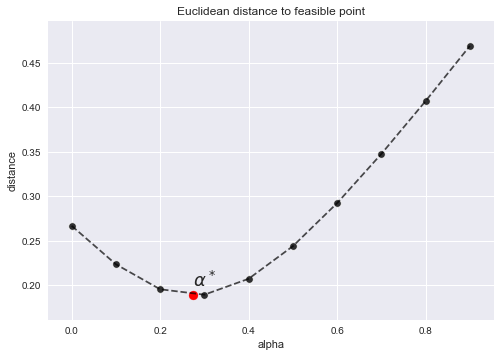

In [15]:
plt.style.use('seaborn')
plt.scatter(alpha_range, proj_dists[:-1], c='black', alpha=0.8, edgecolors='w', linewidth=1, s=60)
plt.scatter(alpha_opt, proj_dists[-1], c='red', s=80)
plt.text(alpha_opt, proj_dists[-1]+0.01, s=r'$\alpha^*$', size=18)
plt.plot(alpha_range, proj_dists[:-1], c='black', linestyle='--', alpha=0.7)
plt.title('Euclidean distance to feasible point')
plt.xlabel('alpha')
plt.ylabel('distance')
plt.show();

In [639]:
import logging
logging.basicConfig(level=logging.INFO)
#logger = logging.getLogger(__name__)
def train_hsvm(w, X, y, C, num_epochs, lr, batch_size, max_lr_attempts, early_stopping, verbose):
    num_samples = len(y)
    y = 2*y - 1
    early_stop_count = 0
    lr_attempts = 0
    init_w = w
    min_loss = np.inf
    best_w = init_w
    if not is_feasible(init_w):
        init_w = proj_boundary(init_w, alpha=0.01)
    if is_feasible(init_w):
        w_new = init_w
        init_loss = loss_fn(init_w, X, y, C)
        for j in range(num_epochs):
            start = time.time()
            current_loss = 0
            shuffle_index = np.random.permutation(num_samples)
            for i in range(0, num_samples, batch_size):
                Xj = X[shuffle_index[i:i+batch_size]]
                yj = y[shuffle_index[i:i+batch_size]]
                grad_w = grad_fn(w_new, Xj, yj, C)
                w_new = w_new - lr*grad_w
                # if not in feasible region, need to use projection
                if not is_feasible(w_new):
                    # solve optimization problem for nearest feasible point
                    alpha_opt = alpha_search(w_new)
                    # project w to feasible sub-space
                    w_new = proj_boundary(w_new, alpha_opt)
                current_loss += loss_fn(w_new, Xj, yj, C)
            current_loss = current_loss / num_samples
            if current_loss < min_loss:
                min_loss = current_loss
                best_w = w_new
            else:
                early_stop_count += 1
                if early_stop_count >= early_stopping:
                    #print('Exiting early: no decrease for ' + str(early_stopping) + ' rounds')
                    break
            if verbose:
                #logger.debug('loss {}'.format(sum_loss))
                print('COMPLETED EPOCH ', j+1)
                print('-------- LOSS: ', current_loss)
                #print('---------- total seconds: ', time.time() - start)
            if lr_attempts < max_lr_attempts:
                if init_loss < min_loss:
                    lr_attempts += 1
                    new_lr = lr / 10
                    print('Retry attempt # ' + str(lr_attempts) + ' with reduced lr: ' + str(new_lr))
                    w_new = init_w
                    early_stop_count = 0
    else:
        print('Error: unable to begin training with initial w (weights)')
    return best_w

In [640]:
from sklearn.svm import LinearSVC

class LinearHSVM():
    """
    Hyperbolic support vector classification model trained in the hyperboloid (Lorentz) model 
    with an iterative, projected gradient descent method
    
    """
    
    def __init__(self, C=1.0, num_epochs=50, lr=0.001, tol=1e-8, batch_size=20, 
                 early_stopping=10, max_retries = 3, verbose=False):
        self.C = C
        self.num_epochs = num_epochs
        self.tol = tol
        self.verbose = verbose
        self.batch_size = batch_size
        self.early_stopping = early_stopping
        self.lr = lr
        self.max_retries = max_retries
        
    def init_weights(self, X, y):
        """
        Initialize w (weights) with the coefficients found from applying
        standard LinearSVC in the ambient Euclidean space
        
        """
        # fit linear svm using scikit-learn classifier
        linear_svm = LinearSVC(fit_intercept=False)
        self.init_coef = linear_svm.fit(X, y).coef_[0]
        # initialize with learned weights
        #if is_feasible(linear_svm_w):
            #print('starting with linsvm weights')
        #    self.init_coef = linear_svm_w
        #else:
            #print('attempting to project linsvm weights')
         #   proj_svm_coef = proj_boundary(linear_svm_w, alpha_search(linear_svm_w))
         #   if is_feasible(proj_svm_coef):
         #       self.init_coef = proj_svm_coef
         #   else:
                #print('using random initialization')
          #      w = np.random.randn(3, )
          #      if is_feasible(w):
          #          self.init_coef = w
          #      else:
          #         self.init_coef = proj_boundary(w, alpha_search(w))
            
        # correct for possible labeling discrepancy (binary labels (0,1) vs. labels (-1, 1))
        #svm.decision_function(x1.reshape(1,-1))
        #self.init_coef[0] = -linear_svm.coef_[0][0]
    
    def fit(self, X, y):
        """
        Train linear HSVM model for input data X, labels y
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        y : array, shape (n_samples, 1)
        """
        self.init_weights(X, y)
        classes = np.unique(y)
        self.class_labels_ = {'neg_class': np.min(classes), 'pos_class': np.max(classes)}
        self.coef_ = train_hsvm(self.init_coef, X, y, self.C, 
                                self.num_epochs, self.lr, self.batch_size,
                                early_stopping=self.early_stopping,
                                max_lr_attempts=self.max_retries, verbose=self.verbose)
        return self

    def predict(self, X):
        """
        Predict class labels with hyperbolic linear decision function
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        """
        y_pred = np.zeros((X.shape[0], ))
        vals = np.array([minkowski_dot(self.coef_, x) for x in X])
        y_pred[vals < 0] = self.class_labels_['neg_class']
        y_pred[vals >= 0] = self.class_labels_['pos_class']
        return y_pred
    
    def score(self, X, y):
        """
        Return mean accuracy evaluated on X, y
        """
        y_pred = self.predict(X)
        return np.sum(y_pred == y) / len(y)
    
    def decision_function(self, X):
        """
        Evaluate minkowski inner product between weights and input data
        """
        vals = np.array([minkowski_dot(self.coef_, x) for x in X])
        return vals

## Basic testing and visualizing decision boundaries

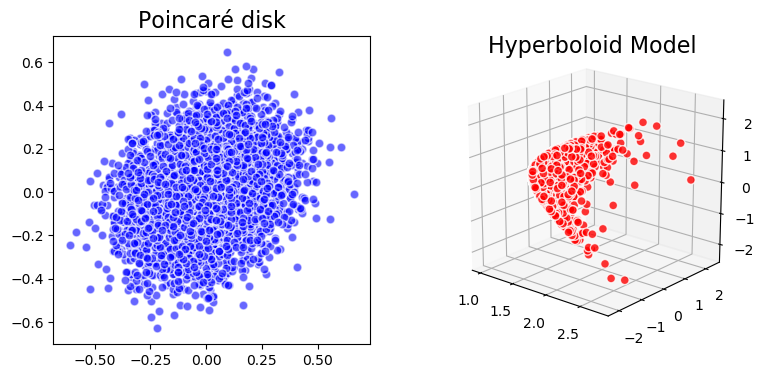

In [590]:
from sklearn.datasets import make_blobs
plt.style.use('default')
centers = [[-0.1,-0.1], [0.1, 0.1]]
X, labels = make_blobs(n_samples=5000, centers=centers, cluster_std=0.15)
data = X
mink_pts = poincare_pts_to_hyperboloid(data)
x = data[:, 0]
y = data[:, 1]

fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(121)
ax.set_title('Poincaré disk', size=16)
ax.scatter(x, y, s=40, c='blue', edgecolor='white', linewidth=1, alpha=0.6);

ax = fig.add_subplot(122, projection = '3d')
ax.scatter(mink_pts[:, 0], mink_pts[:, 1], mink_pts[:, 2], c='red', 
           alpha=0.8, s=40, edgecolor='white', linewidth=1)
ax.set_title('Hyperboloid Model', size=16);
ax.view_init(20, -50);
plt.show();

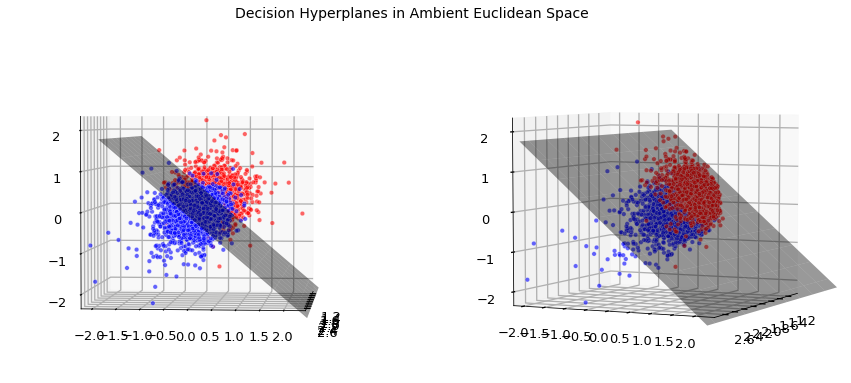

In [591]:
from sklearn.svm import LinearSVC
hsvm_clf = LinearHSVM(early_stopping=1, C=0.1, num_epochs=20, lr=0.00001, verbose=False)
hsvm_clf.fit(mink_pts, labels)
hsvm_clf.coef_
plt.style.use('seaborn-talk')
X = mink_pts
z = lambda x,y: (-hsvm_clf.coef_[0]*x-hsvm_clf.coef_[1]*y) / hsvm_clf.coef_[2]
x_range = np.linspace(0, 3, 20)
y_range = np.linspace(-1.8, 2.5, 20)
x,y = np.meshgrid(x_range, y_range)

%matplotlib inline
import matplotlib

fig = plt.figure(figsize=(15,6))
ax  = fig.add_subplot(121, projection='3d')
ax.set_xlim([np.min(X, axis=0)[0], np.max(X, axis=0)[0]])
ax.set_ylim([np.min(X, axis=0)[1], np.max(X, axis=0)[1]])
ax.set_zlim([np.min(X, axis=0)[2], np.max(X, axis=0)[2]])
ax.plot_surface(x, y, z(x,y), color='k', alpha=0.4, rstride=2, cstride=2, linewidth=.1)
ax.scatter(X[labels==0,0], X[labels==0,1], X[labels==0,2], c='blue', alpha=0.6, edgecolors='w')
ax.scatter(X[labels==1,0], X[labels==1,1], X[labels==1,2], c='red', alpha=0.6, edgecolors='w')
ax.view_init(3, 5)

ax  = fig.add_subplot(122, projection='3d')
ax.set_xlim([np.min(X, axis=0)[0], np.max(X, axis=0)[0]])
ax.set_ylim([np.min(X, axis=0)[1], np.max(X, axis=0)[1]])
ax.set_zlim([np.min(X, axis=0)[2], np.max(X, axis=0)[2]])
ax.plot_surface(x, y, z(x,y), color='k', alpha=0.4, rstride=2, cstride=2, linewidth=.1)
ax.scatter(X[labels==0,0], X[labels==0,1], X[labels==0,2], c='blue', alpha=0.6, edgecolors='w')
ax.scatter(X[labels==1,0], X[labels==1,1], X[labels==1,2], c='red', alpha=0.6, edgecolors='w')
ax.view_init(5, 25)
plt.suptitle(t='Decision Hyperplanes in Ambient Euclidean Space', size=14)
plt.show();

In [566]:
# fit hsvm on another simple test clustering dataset
centers = [[-0.41,-0.40], [-0.1, -0.1]]
X, labels = make_blobs(n_samples=5000, centers=centers, cluster_std=0.05)
data = X
mink_pts = poincare_pts_to_hyperboloid(data)
hsvm_clf = LinearHSVM(early_stopping=10, C=1, num_epochs=30, lr=0.01, verbose=False)
hsvm_clf.fit(mink_pts, labels)
w = hsvm_clf.coef_
# get approximate intersection of hyperplane and L2
L2 = poincare_pts_to_hyperboloid(np.random.randn(100000, 2))
inter = np.array([np.abs(minkowski_dot(x, w)) for x in L2]) < 1e-2
L2[inter].shape
hsvm_clf.score(mink_pts, labels)

(168, 3)

1.0

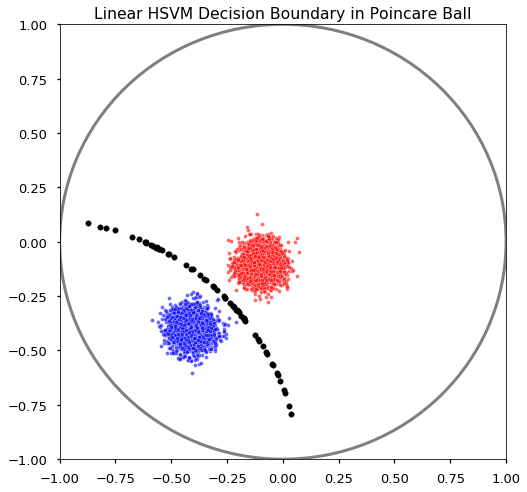

In [567]:
# plot decision boundary in poincare ball
dec_bound = L2[inter]
ball_dec = hyperboloid_pts_to_poincare(dec_bound)
ball_dec = ball_dec[norm(ball_dec, axis=1) < 1]
%matplotlib inline
fig = plt.figure(figsize=(8,8))
ax = plt.gca()
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
plt.scatter(ball_dec[:, 0], ball_dec[:, 1], s=30, color='black')
plt.scatter(X[labels==0,0], X[labels==0,1], c='blue', alpha=0.6, edgecolors='w', s=15)
plt.scatter(X[labels==1,0], X[labels==1,1], c='red', alpha=0.6, edgecolors='w', s=15)
plt.xlim([-1.,1.])
plt.ylim([-1.,1.])
plt.title('Linear HSVM Decision Boundary in Poincare Ball')
plt.show();

Exiting early: no decrease for 1 rounds
Exiting early: no decrease for 1 rounds
Exiting early: no decrease for 1 rounds
Exiting early: no decrease for 1 rounds
Exiting early: no decrease for 1 rounds
Exiting early: no decrease for 1 rounds
Exiting early: no decrease for 1 rounds
Exiting early: no decrease for 1 rounds
Exiting early: no decrease for 1 rounds
Exiting early: no decrease for 1 rounds
Exiting early: no decrease for 1 rounds
Exiting early: no decrease for 1 rounds
Exiting early: no decrease for 1 rounds
Exiting early: no decrease for 1 rounds
Exiting early: no decrease for 1 rounds
Exiting early: no decrease for 1 rounds
Exiting early: no decrease for 1 rounds


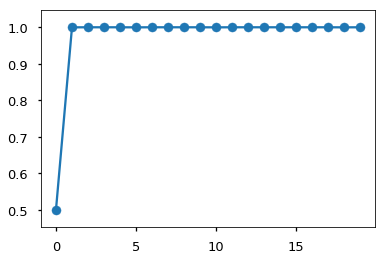

In [143]:
centers = [[-0.41,-0.40], [-0.1, -0.1]]
X, labels = make_blobs(n_samples=5000, centers=centers, cluster_std=0.05)
data = X# / (np.max(norm(X, axis=1)) - 1e-3)
mink_pts = poincare_pts_to_hyperboloid(data)
scores = []
weights = []
for i in np.arange(0, 20):
    hsvm_clf = LinearHSVM(early_stopping=1, C=1, num_epochs=2*i, lr=0.01, verbose=False)
    w = hsvm_clf.fit(mink_pts, labels).coef_
    scores.append(hsvm_clf.score(mink_pts, labels))
    weights.append(hsvm_clf.coef_)

plt.scatter(np.arange(0, 20), scores)
plt.plot(scores);

False


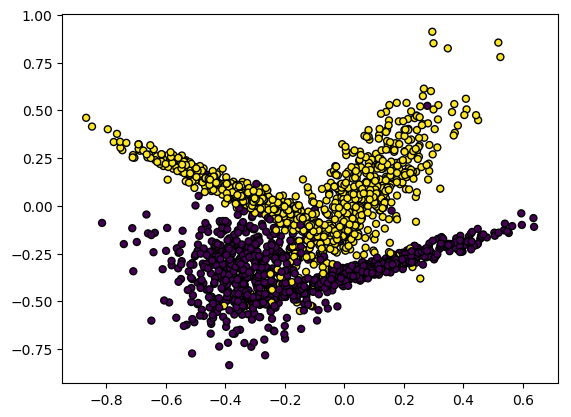

In [183]:
from sklearn.datasets import make_moons, make_classification
plt.style.use('default')
X, labels = make_classification(n_features=2, n_redundant=0, n_informative=2,
                                n_samples=2000, scale=.2, shift=-0.7)
data = X
data[(norm(X, axis=1) > 1)] = data[(norm(X, axis=1) > 1)] / (np.max(norm(X, axis=1)))
print((norm(data, axis=1) > 1).any())
mink_pts = poincare_pts_to_hyperboloid(data)
plt.scatter(data[:, 0], data[:, 1], marker='o', c=labels, s=25, edgecolor='k');

In [184]:
hsvm_clf = LinearHSVM(early_stopping=10, C=1, num_epochs=50, lr=0.01, verbose=True)
hsvm_clf.fit(mink_pts, labels)
w = hsvm_clf.coef_
L2 = poincare_pts_to_hyperboloid(np.random.randn(100000, 2))
inter = np.array([np.abs(minkowski_dot(x, w)) for x in L2]) < 1e-2
L2[inter].shape
hsvm_clf.score(mink_pts, labels)

COMPLETED EPOCH  1
-------- LOSS:  0.6787458681427279
COMPLETED EPOCH  2
-------- LOSS:  0.40709934701910067
COMPLETED EPOCH  3
-------- LOSS:  0.4059495216608105
COMPLETED EPOCH  4
-------- LOSS:  0.4053008664610801
COMPLETED EPOCH  5
-------- LOSS:  0.4065252805559751
COMPLETED EPOCH  6
-------- LOSS:  0.40533107288262443
COMPLETED EPOCH  7
-------- LOSS:  0.40544193227269576
COMPLETED EPOCH  8
-------- LOSS:  0.40663345546931895
COMPLETED EPOCH  9
-------- LOSS:  0.407379002951206
COMPLETED EPOCH  10
-------- LOSS:  0.4060234897659883
COMPLETED EPOCH  11
-------- LOSS:  0.40499827645420083
COMPLETED EPOCH  12
-------- LOSS:  0.40784086693337795
COMPLETED EPOCH  13
-------- LOSS:  0.40702448545231196
COMPLETED EPOCH  14
-------- LOSS:  0.4054298966477615
COMPLETED EPOCH  15
-------- LOSS:  0.40423877260892704
Exiting early: no decrease for 10 rounds


(188, 3)

0.878

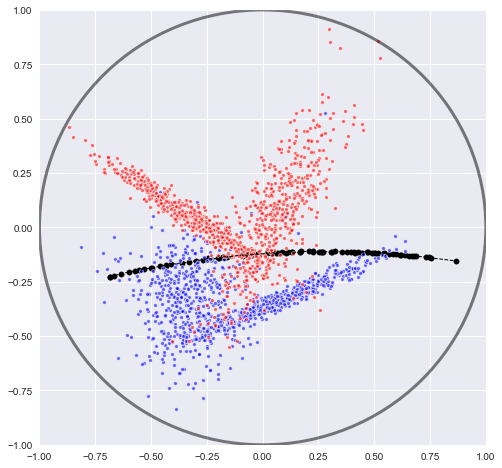

In [187]:
dec_bound = L2[inter]
ball_dec = hyperboloid_pts_to_poincare(dec_bound)
ball_dec = ball_dec[norm(ball_dec, axis=1) < 1]
%matplotlib inline
plt.style.use('seaborn')
fig = plt.figure(figsize=(8,8))
ax = plt.gca()
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
X = data
plt.scatter(ball_dec[:, 0], ball_dec[:, 1], s=30, color='black')
x=ball_dec[:,0]
y=ball_dec[:,1]
x_new = np.linspace(x.min(), x.max(),500)
f = interp1d(x, y, kind='slinear')
y_smooth=f(x_new)
plt.plot(x_new,y_smooth, color='black', linewidth=1, linestyle='--')
plt.scatter(X[labels==0,0], X[labels==0,1], c='blue', alpha=0.6, edgecolors='w', linewidths=1, s=15)
plt.scatter(X[labels==1,0], X[labels==1,1], c='red', alpha=0.6, edgecolors='w', linewidths=1, s=15)
plt.xlim([-1.,1.])
plt.ylim([-1.,1.])
plt.show();

# Evaluating LinearHSVM

In [521]:
def proj_ball(X, eps=1e-3):
    out_pts = norm(X, axis=1) > 1
    num_pts = np.sum(out_pts)
    X[out_pts] = X[out_pts] / norm(X[out_pts], axis=0) - np.repeat(eps, num_pts).reshape(-1,1)
    return X

def get_gaussian_data(path):
    """Load data from matlab files"""
    data = sp.io.loadmat(path)
    X, y = data['B'], data['label'].ravel().astype(np.int)
    class_labels = np.unique(y)
    print('Loaded data X with shape: ' + str(X.shape) + ' ,labels Y with ' + str(len(class_labels)) + ' classes.')
    # project points within the poincare ball
    if (norm(X, axis=1) > 1).any():
        out_pts = norm(X, axis=1) > 1
        num_pts = np.sum(out_pts)
        X[out_pts] = X[out_pts] / norm(X[out_pts], axis=0) - np.repeat(eps, num_pts).reshape(-1,1)

    return X, y

In [578]:
import os
import scipy.io as sio
path = 'C:/Users/dreww/Desktop/hyplinear-master/data/gaussian'
mat_files = []
for f in os.listdir(path):
    mat_files.append(path + '/' + f)

Flesh out a cross-validation program for one vs. all classification

In [653]:
from sklearn.metrics import roc_auc_score, accuracy_score, auc, precision_recall_curve
from sklearn.model_selection import ShuffleSplit, cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import label_binarize

def eval_gaussian(path, n_trials=5, n_splits=2):
    X,y = get_gaussian_data(path)
    n_classes = len(np.unique(y))
    y_binary = label_binarize(y, classes=[1, 2, 3, 4])
    #cv = ShuffleSplit(n_splits=2, test_size=0.5, random_state=None)
    #skf = StratifiedKFold(n_splits=2, shuffle=True)
    cv = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.4, random_state=None)
    results_dict = {}
    binary_roc_scores = np.zeros((n_classes, n_trials))
    binary_acc_scores = np.zeros((n_classes, n_trials))
    binary_auc_pr = np.zeros((n_classes, n_trials))
    roc_results = []
    acc_results = []
    for i in range(n_classes):
        for k in range(n_trials):
            for train_index, test_index in cv.split(poincare_pts_to_hyperboloid(X), y_binary):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y_binary[train_index, i], y_binary[test_index, i]
                hsvm = LinearHSVM(early_stopping=1, C=1, num_epochs=25, lr=0.00001, batch_size=10, verbose=False)
                hsvm.fit(X_train, y_train)
                pred_scores = hsvm.decision_function(X_test)
                roc_results.append(roc_auc_score(y_test, pred_scores))
                acc_results.append(hsvm.score(X_test, y_test))
                precision, recall, _ = precision_recall_curve(y_test, pred_scores)
            binary_auc_pr[i, k] = np.mean(auc(recall, precision))    
            binary_roc_scores[i, k] = np.mean(roc_results)
            binary_acc_scores[i, k] = np.mean(acc_results)
    results_dict['roc'] = binary_roc_scores
    results_dict['auc_pr'] = binary_auc_pr
    results_dict['acc'] = binary_acc_scores
    return results_dict

In [654]:
test_results = []
for file in mat_files[::7]:
    print(file.upper())
    trial_dict = eval_gaussian(file)
    test_results.append(trial_dict)

C:/USERS/DREWW/DESKTOP/HYPLINEAR-MASTER/DATA/GAUSSIAN/DATA_001.MAT
Loaded data X with shape: (400, 2) ,labels Y with 4 classes.
C:/USERS/DREWW/DESKTOP/HYPLINEAR-MASTER/DATA/GAUSSIAN/DATA_008.MAT
Loaded data X with shape: (400, 2) ,labels Y with 4 classes.
C:/USERS/DREWW/DESKTOP/HYPLINEAR-MASTER/DATA/GAUSSIAN/DATA_015.MAT
Loaded data X with shape: (400, 2) ,labels Y with 4 classes.
C:/USERS/DREWW/DESKTOP/HYPLINEAR-MASTER/DATA/GAUSSIAN/DATA_022.MAT
Loaded data X with shape: (400, 2) ,labels Y with 4 classes.
Error: unable to begin training with initial w (weights)
Error: unable to begin training with initial w (weights)
C:/USERS/DREWW/DESKTOP/HYPLINEAR-MASTER/DATA/GAUSSIAN/DATA_029.MAT
Loaded data X with shape: (400, 2) ,labels Y with 4 classes.
C:/USERS/DREWW/DESKTOP/HYPLINEAR-MASTER/DATA/GAUSSIAN/DATA_036.MAT
Loaded data X with shape: (400, 2) ,labels Y with 4 classes.
Error: unable to begin training with initial w (weights)
Error: unable to begin training with initial w (weights)
Erro

In [655]:
np.mean([d['roc'] for d in test_results])
np.mean([d['auc_pr'] for d in test_results])
np.mean([d['acc'] for d in test_results])

0.39285309851788697

0.26559440556721814

0.4152305750529749

Loaded data X with shape: (400, 2) ,labels Y with 4 classes.
COMPLETED EPOCH  1
-------- LOSS:  1.275689118607647
COMPLETED EPOCH  2
-------- LOSS:  1.2215187738504985
COMPLETED EPOCH  3
-------- LOSS:  1.1868930592227032
COMPLETED EPOCH  4
-------- LOSS:  1.161584897231447
COMPLETED EPOCH  5
-------- LOSS:  1.1404945390628625
COMPLETED EPOCH  6
-------- LOSS:  1.122001574631676
COMPLETED EPOCH  7
-------- LOSS:  1.1055645405403167
COMPLETED EPOCH  8
-------- LOSS:  1.0900953734515328
COMPLETED EPOCH  9
-------- LOSS:  1.0753754307851777
COMPLETED EPOCH  10
-------- LOSS:  1.060613005551091
COMPLETED EPOCH  11
-------- LOSS:  1.0458528093997075
COMPLETED EPOCH  12
-------- LOSS:  1.0306574680885336
COMPLETED EPOCH  13
-------- LOSS:  1.0152839712140003
COMPLETED EPOCH  14
-------- LOSS:  1.0001231711589034
COMPLETED EPOCH  15
-------- LOSS:  0.9843600818143758
COMPLETED EPOCH  16
-------- LOSS:  0.9680061481285632
COMPLETED EPOCH  17
-------- LOSS:  0.9500829797807139
COMPLETED EPOCH  

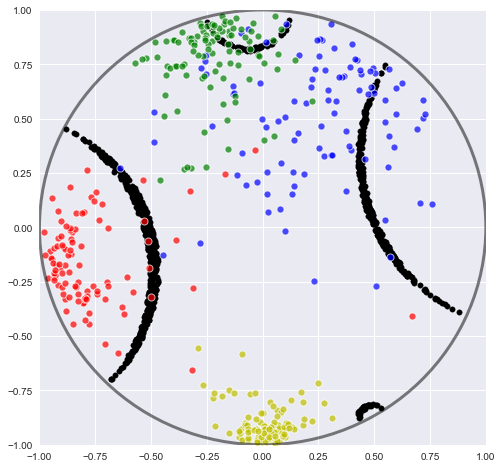

In [646]:
def plot_gaussian(X, labels):
    plt.style.use('seaborn')
    fig = plt.figure(figsize=(8,8))
    y_binary = label_binarize(labels, classes=[1, 2, 3, 4])
    hsvm_clf = LinearHSVM(early_stopping=5, C=1, num_epochs=20, lr=0.00001, verbose=True, batch_size=24)
    for i in range(y_binary.shape[1]):
        hsvm_clf.fit(poincare_pts_to_hyperboloid(X), y_binary[:, i])
        w = hsvm_clf.coef_
        print(hsvm_clf.score(poincare_pts_to_hyperboloid(X), y_binary[:, i]))
        L2 = poincare_pts_to_hyperboloid(np.random.randn(100000, 2))
        inter = np.array([np.abs(minkowski_dot(x, w)) for x in L2]) < 1e-2
        dec_bound = L2[inter]
        ball_dec = hyperboloid_pts_to_poincare(dec_bound)
        ball_dec = ball_dec[norm(ball_dec, axis=1) < 1]
        plt.scatter(ball_dec[:, 0], ball_dec[:, 1], s=30, color='black')
    colors = ['b', 'r', 'g', 'y']
    ax = plt.gca()
    circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
    ax.add_patch(circ)
    for i in range(y_binary.shape[1]):
        plt.scatter(X[labels==i+1,0], X[labels==i+1,1], c=colors[i],
                    alpha=0.7, edgecolors='w', linewidths=1, s=50)
    plt.xlim([-1.,1.])
    plt.ylim([-1.,1.])
    plt.show();

X, y = get_gaussian_data(mat_files[48])
plot_gaussian(X, y);